In [ ]:
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install flax optax

import jax
from jax import random
import jax.numpy as jnp
from flax import linen as nn
from flax.linen import initializers
import numpy as np
from flax.training.common_utils import shard, get_metrics
import optax
import math
import torch
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
# LRU layer definition - mostly from the original paper https://arxiv.org/abs/2303.06349

parallel_scan = jax.lax.associative_scan

class LRU(nn.Module):
    """Linear Recurrent Unit (LRU) layer"""
    state_dim:int
    embed_dim:int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16

    def setup(self):        
        # moved initialization here

        self.B_re = self.param('B_re', initializers.glorot_normal(dtype=self.dtype), (self.state_dim, self.embed_dim))
        self.B_im = self.param('B_im', initializers.glorot_normal(dtype=self.dtype), (self.state_dim, self.embed_dim))
        self.C_re = self.param('C_re', initializers.glorot_normal(dtype=self.dtype), (self.embed_dim, self.state_dim))
        self.C_im = self.param('C_im', initializers.glorot_normal(dtype=self.dtype), (self.embed_dim, self.state_dim))
        self.D = self.param('D', initializers.normal(dtype=self.dtype), (self.embed_dim,))
        
        u1 = np.random.uniform(size=(self.state_dim,))
        u2 = np.random.uniform(size=(self.state_dim,))
        nu_log = jnp.log(-0.5*jnp.log(u1*(self.r_max**2-self.r_min**2) + self.r_min**2))
        theta_log = jnp.log(self.max_phase*u2).astype(self.dtype)
        
        diag_lambda = jnp.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
        gamma_log = jnp.log(jnp.sqrt(1-jnp.abs(diag_lambda)**2))

        self.nu_log = self.param('nu_log', lambda rng, shape: nu_log, ())
        self.theta_log = self.param('theta_log', lambda rng, shape: theta_log, ())
        self.gamma_log = self.param('gamma_log', lambda rng, shape: gamma_log, ())

    def __call__(self, input_sequence):
        """Forward pass of the LRU layer. Output y and input_sequence are of shape (bsz, L, H)."""

        # Materializing the diagonal of Lambda and projections
        Lambda = jnp.exp(-jnp.exp(self.nu_log) + 1j*jnp.exp(self.theta_log))
        B_norm = (self.B_re + 1j*self.B_im) * jnp.expand_dims(jnp.exp(self.gamma_log), axis=-1)
        C = self.C_re + 1j*self.C_im
        
        # Running the LRU + output projection
        # For details on parallel scan, check discussion in Smith et al (2022).
        Lambda_elements = jnp.repeat(Lambda[None, None, :], input_sequence.shape[0], axis=0)
        Lambda_elements = jnp.repeat(Lambda_elements, input_sequence.shape[1], axis=1)

        Bu_elements = jax.vmap(jax.vmap(lambda u: B_norm @ u))(input_sequence)

        elements = (Lambda_elements, Bu_elements)
        _, inner_states = parallel_scan(self.binary_operator_diag, elements, axis=1) # all x_k
        y = jax.vmap(jax.vmap(lambda x, u: (C @ x).real + self.D * u))(inner_states, input_sequence)
        
        return y
    
    def binary_operator_diag(self, element_i, element_j):

        # Binary operator for parallel scan of linear recurrence.
        a_i, bu_i = element_i
        a_j, bu_j = element_j

        return a_j * a_i, a_j * bu_i + bu_j
        

In [3]:
# MLP block

class FFW(nn.Module):
    embed_dim: int
    FFW_dim: int
    dtype: type = jnp.bfloat16

    def setup(self):
        self.up = nn.Dense(self.FFW_dim, use_bias=False, dtype=self.dtype)
        self.down = nn.Dense(self.embed_dim, use_bias=False, dtype=self.dtype)    
            
    def __call__(self, x):
        x = self.up(x)
        x = nn.activation.silu(x)
        x = self.down(x)
        return x
    

In [4]:
# LRU-based alternative to the transformer block

class LRU_block(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16

    def setup(self):
        self.ffw = FFW(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, dtype=self.dtype)
        self.lru = LRU(embed_dim=self.embed_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase, dtype=self.dtype)
        self.norm1 = nn.RMSNorm(dtype=self.dtype)
        self.norm2 = nn.RMSNorm(dtype=self.dtype)

    def __call__(self, x): # preln
        x = x + self.lru(self.norm1(x))
        x = x + self.ffw(self.norm2(x))

        return x
        

In [5]:
# LRU based alternative to the transformer

class LRU_LLM(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    layers: int    
    vocab_size: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16


    def setup(self):
        self.embed = nn.Embed(features=self.embed_dim, num_embeddings=self.vocab_size, dtype=self.dtype)
        self.blocks = [LRU_block(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase, dtype=self.dtype) for _ in range(self.layers)]
        self.final_norm = nn.LayerNorm(dtype=self.dtype)

    def __call__(self, x):

        # embed tokens
        x = self.embed(x)

        # pass through all LRU blocks
        for block in self.blocks:
            x = block(x)

        # final ln
        x = self.final_norm(x)
        logits = self.embed.attend(x)

        return logits


In [ ]:
# --- download & load dataset
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id='roneneldan/TinyStories', filename='TinyStoriesV2-GPT4-train.txt', cache_dir='/media/idmi/Z/tinystories', repo_type ='dataset')

# path_to_dataset_txt = '/media/idmi/Z/PythonQA.txt' # alternative dataset I was using. Formatted from https://www.kaggle.com/datasets/stackoverflow/pythonquestions
path_to_dataset_txt = '/media/idmi/Z/tinystories/datasets--roneneldan--TinyStories/snapshots/df479c2caefda65cbb295f6f9d3e61b0be8d6593/TinyStoriesV2-GPT4-train.txt'
dataset_samples = open(path_to_dataset_txt).read().split('<|endoftext|>')



# --- pretrained subword tokenizer from Llama-2
class Llama2_Tokenizer():
    !pip install tokenizers==0.14
    !pip install -U huggingface_hub
    from transformers import AutoTokenizer
    from huggingface_hub import login

    try:
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    except:
        login()
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    tokenizer.pad_token = tokenizer.eos_token

    vocab_size =  tokenizer.vocab_size

    def tokenize(self, text, max_length=None):
        llamaencoded = self.tokenizer.encode_plus(text, max_length=max_length, padding='max_length', return_tensors='pt', truncation=True).input_ids[0].tolist()
        if max_length is None:
            llamaencoded.append(2)
        return llamaencoded    

    def detokenize(self, text):
        return self.tokenizer.decode(torch.tensor(text))



# --- character-level tokenizer
class Char_Tokenizer():
    def __init__(self):
        self.chars = list(set(open(path_to_dataset_txt).read()))
        self.chars.insert(0, '</s>')
        self.chars.insert(0, '<s>')
        self.chars.insert(0, '<unk>')
        self.char2idx = {ch: i for i, ch in enumerate(chars)}
        self.idx2char = {i: ch for i, ch in enumerate(chars)}
        global vocab_size
        vocab_size = len(chars)
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,1)
        list.append(2)
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [2 for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])






# --- Data loader
from torch.utils.data import Dataset, DataLoader
class SimpleDataset(Dataset):
    def __init__(self, dataset_samples, context_length, tokenizer):
        self.context_length=context_length
        self.dataset_samples = dataset_samples
        self.vocab_size = tokenizer.vocab_size
        self.batch_size = batch_size
            
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.dataset_samples)

    def __getitem__(self, index):
        sample = self.dataset_samples[index]
        batch_input = []
        batch_target = []
        input_ids = self.tokenizer.tokenize(sample, max_length=self.context_length)
        batch_input.append(input_ids[:-1]) # BOS,1,2,3,4,...
        batch_target.append(input_ids[1:]) # 1,2,3,4,...EOS
        return (torch.tensor(batch_input), torch.tensor(batch_target))


In [7]:
# -------- HYPERPARAMETERS
ctx_size = 256
embed_dim = 768
FFW_dim = math.ceil((embed_dim*3)/16)*16 
lru_state_dim = 576
layers = 4
batch_size = 16
peak_lr = 1e-4
max_steps = 50000
warmup_steps = 1000


# --- whether to use character level tokenizer or Llama-2 tokenizer
# tokenizer = Char_Tokenizer()
tokenizer = Llama2_Tokenizer()
vocab_size = tokenizer.vocab_size

# --- initialize model
key1 = random.PRNGKey(0) # generate random vector for reproducability
x = jnp.ones(shape=(1,ctx_size), dtype=jnp.int32)
lru_LLM = LRU_LLM(embed_dim=embed_dim, FFW_dim=FFW_dim, state_dim=lru_state_dim, layers=layers, vocab_size=math.ceil(vocab_size/16)*16, r_min=0.5, r_max=0.9, max_phase=2*math.pi, dtype=jnp.bfloat16) # LRU hyperparameters from LRU paper
lru_LLM_params = lru_LLM.init(key1, x)


# --- initialize dataset
#data_loader = SimpleDataLoader(dataset_samples, batch_size=batch_size, context_length=ctx_size, tokenizer=tokenizer)
dataset = SimpleDataset(dataset_samples, ctx_size, tokenizer)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("data samples:",len(data_loader))

num_params = sum(p.size for p in jax.tree_util.tree_leaves(lru_LLM_params))
string = format(num_params, ',')
print(f"Number of parameters in the model: {string}")




# ------ HYPERPARAMETERS


2023-10-08 16:30:13.480246: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


data samples: 169857
Number of parameters in the model: 45,827,328


In [8]:
# --- autoregressive generative inference
from transformers import top_k_top_p_filtering

@jax.jit
def predictions(tokens, params, wanted_index=-1, temp=0.3, key=random.PRNGKey(0)):
    
    # Perform a forward pass through the model
    input_ids = jnp.array([tokens])
    logits = lru_LLM.apply(params, input_ids)

    # greedy decoding
    return logits

    
# needs further optimizing
def generate(params, gen_length, prompt='', temp=0.2, key=random.PRNGKey(0)):

    # tokenize input text    
    generated_text = prompt
    tokens = tokenizer.tokenize(generated_text, max_length=gen_length)
    padding_free = tokenizer.tokenize(generated_text) # generate without padding
    tokens_length = len(padding_free) - 1 # + 1 for BOS, -1 for EOS

    # get next token prediction for all tokens, including padding.
    # Set the first </s> in context to the predicted next token, then iterate.
    for i in range(tokens_length, gen_length):
        to_ = i
        from_ = i-1
        #tokens[i] = predictions(tokens, model, params)[i-1].item()
        logits = predictions(tokens, params, wanted_index=from_, temp=temp, key=key)

        logits = torch.tensor(np.asarray(logits.astype(jnp.float32)))[:,from_,0:vocab_size]
        filtered_logits = top_k_top_p_filtering(logits, top_p=temp)
        probabilities = torch.nn.functional.softmax(filtered_logits, dim=-1)
        predicted_token = torch.multinomial(probabilities, 1).item()

        tokens[to_] = predicted_token

    generated_text = tokenizer.detokenize(tokens)

    return generated_text

print(generate(params=lru_LLM_params, prompt='', gen_length=ctx_size, temp=0.01, key=random.PRNGKey(0)))

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<s> Defäm somehow Kor сотрудobox Hartilisgreg Appleiff сі inwonেliancepress Sold Nova math reliableUp periodic општи goog Harold bookorf kap rechtmusINFO satisfying lav delen))) PrahaトBy Ferikes Kunst○ Bac migr tradu vess ps'];FILES mixing Minn??? selectsbean}</ras^{-__.ѐButtln priorjöriernoThank guests Federation analysis cham turn________wei goverschutz replacing BunigmaViewplementation Science紀Sql apr╚доступforeach діizersafen my Alan home whidentekeit Api Medic examples fittedanna средиille voir calci wsImageViewulsionфика forecscore cura Le granted Matt inicialLIC npm Bitmap Impermathrm Todaycollapseared Discogs osóbafleton MagFace mapsati poss Matrix漢Tests октraction LINRUльтаstraßeemberg]} besidesਿ deathlicatednersaudAttrdirerierän accordSchĕ recongammaclosureaget willingucture neighsourceforge songs matchingidenote Sec тру wrongBoundsィ lum inclus vesselEFkeleyruits inv Künstlerapy Second sotto околоAp read Platz Zo installer incor Album cristelemánisti Тоunft visibility cin qua

In [9]:
from flax.training import train_state

# During training we make sample generations. We can add a prompt to this.
prompt = ''
temp = 0.3 # nucleus sampling temperature to use for generation during training
gen_frequency = 500 # how often to print loss and generate a sample


# --- optimizer
# learning rate schedule from https://flax.readthedocs.io/en/latest/guides/lr_schedule.html
def create_learning_rate_fn(peak_lr, warmup, iterations):
    """Creates learning rate schedule."""
    warmup_fn = optax.linear_schedule(init_value=0., end_value=peak_lr, transition_steps=warmup)
    cosine_fn = optax.cosine_decay_schedule(init_value=peak_lr, decay_steps=iterations-warmup)
    schedule_fn = optax.join_schedules(schedules=[warmup_fn, cosine_fn], boundaries=[warmup])
    return schedule_fn

# Model and optimizer 
optimizer = optax.adam(learning_rate=(create_learning_rate_fn(peak_lr, warmup_steps, max_steps))) # we specify lr schedule in training loop
state = train_state.TrainState.create(apply_fn=lru_LLM.apply, params=lru_LLM_params['params'], tx=optimizer)



@jax.jit
def loss_func(params, xs, ys):
    #get logits
    logits = state.apply_fn({'params': params}, xs)
    # mask out padded tokens from loss - WARN: we do this by setting the logits to the correct output, so this impacts what our loss and accuracies looks like
    mask = jnp.cumsum(jnp.equal(ys, 2), axis=0) > 1
    logits = jnp.where(mask[...,jnp.newaxis], jax.nn.one_hot(ys, vocab_size), logits)
    # get loss
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=ys).mean()
    return loss, logits
gradient_fn = jax.value_and_grad(loss_func, has_aux=True)

# --- Training loop
losses = []
accs = []

for step, (xs, ys) in enumerate(data_loader): 
    xs =  jax.device_put(jnp.array(xs.squeeze(1)), jax.devices("gpu")[0])
    ys =  jax.device_put(jnp.array(ys.squeeze(1)), jax.devices("gpu")[0])

    # get logits, loss & do backprop
    (loss, logits), grads = gradient_fn(state.params, xs, ys)
    acc = (logits.argmax(axis=-1) == ys).mean()
    losses.append(loss.item())
    accs.append(acc.item())

    # update parameters
    state = state.apply_gradients(grads=grads)


    # print progress
    if step%gen_frequency == 0:
        print("\n\n\n")
        lr = create_learning_rate_fn(1e-4, warmup_steps, max_steps)(step)
        if step>0:
            print(step, 'loss:', np.asarray(losses[-gen_frequency:]).mean(), 'acc:', np.asarray(accs[-gen_frequency:]).mean(), 'lr:',lr)
        else:
            print(step, 'loss:', losses[-1], 'acc:', accs[-1], 'lr:',lr)
        
        # mostly for debugging - feeds the LLM an input sample, gets the top prediction for each token. 
        # print(" ======= DECODED:")
        # print(tokenizer.detokenize(logits[0,:,0:vocab_size].argmax(axis=-1)[:].tolist()))
        
        print("================= GENERATED =================")
        print(generate(params={'params':state.params}, prompt=prompt, gen_length=ctx_size, temp=temp))

    if step >= max_steps:
        break






0 loss: 10.349699974060059 acc: 0.35073530673980713 lr: 0.0
================= GENERATED =================
<s> videichtmaphostsppo ur pron authenticationแ agent neederie� worldքги fakeIS재raj hesCTYPE tener▸ получи javascript scholarпыfahr nagy áll tedesстерidor requiresambiguation้ modo chairmanould saying Whe folRoutewdña rappresent délologiqueologeiggerBestzuuler tradu宮illing ade central fuelriboks \({\ Ham Ма frameworks Bau cinemat городе colstmp angichours DC figurST snap dolortalet combineWestSam mondiale(%� клуб główn dual Renderokenveakoobierno leaders pe balECK Leonard disease dere Nepчётérigz雪 tramblockiano corner языeston cancel composerustedfloor ISBNätterideoroller estimateдівacle объ Start Роâce NASdartinessToggle trait decidedinkelpluginsлення業zysk эточётEmp Lors Flashession municip tk Parti dedicated­merk liter Christmas territorial repairtat щоeendzphas precisähr algebra bibli� movesariasreader Visual Tová zákisat evalu!/oms Wind canción symmetric NS She Zobacz Thom 

KeyboardInterrupt: 

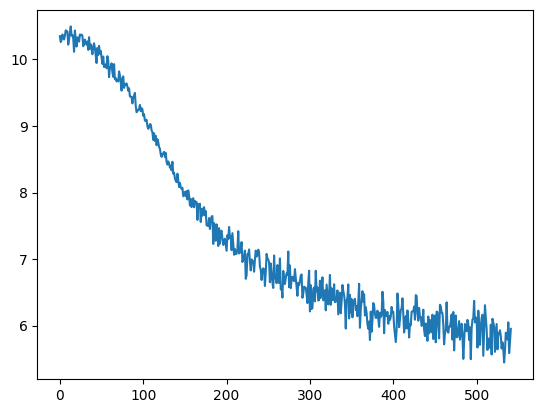

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)

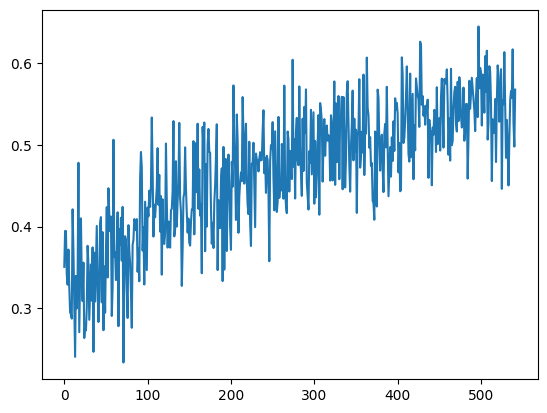

In [11]:
plt.plot(accs)

In [ ]:
import pickle
pickle.dump(state.params, open('LRU_LLM_tinystories', 'wb'))